In [1]:
from Helpers import *
from FLController import *
from ILQGController import *

In [21]:
def VerifyVel(X0 = [70,70],XN=[-10,100],less = 0,timings = [.5,.75,1],onlyILQG=False):
    start = ToCartesian(np.array(X0)/180*pi)
    end = ToCartesian(np.array(XN)/180*pi)
    plt.figure(dpi=200,figsize = (4,4))
    for timing in timings:
        K = int(timing/.01)
        xILQG,yILQG,uILQG,x = ILQG(timing,1e7,1e4,1e-4,end,K-less,start,Delay=0)
        
        if onlyILQG==False : X,Y = Feedback_Linearization(timing,1e7,1e7,1e4,1e4,1e-4,1e-4,end,start,Num_iter=K)
    plt.plot(np.linspace(start[0],end[0],100),np.linspace(start[1],end[1],100),color = "grey",alpha = .4,linestyle = "--")
    MultipleLabel()
    plt.show()
    for timing in timings:
        K = int(timing/.01)
        xILQG,yILQG,uILQG,x = ILQG(timing,1e7,1e4,1e-4,end,K-less,start,Delay=0,plot=False)
        plt.plot(np.linspace(0,timing,x.shape[0]),x[:,2],label = "Shoulder ILQG",color = (0.51,0.25,0.7))
        plt.plot(np.linspace(0,timing,x.shape[0]),x[:,3],label = "Elbow ILQG",color = (0.44,0.91,0.86))
        plt.plot(np.linspace(0,timing,100),np.zeros(100),color = "grey",linestyle = "--",linewidth = 1)
        if onlyILQG == False:
            X,Y,J,x = Feedback_Linearization(timing,1e7,1e7,1e4,1e4,1e-4,1e-4,end,start,Num_iter=K,plot = False,ShowJ=True)
            plt.plot(np.linspace(0,timing,x.shape[0]),x[:,2],label = "Shoulder FL",color = (0.51,0.25,0.7),linestyle = "dotted")
            plt.plot(np.linspace(0,timing,x.shape[0]),x[:,3],label = "Elbow FL",color = (0.44,0.91,0.86),linestyle = "dotted")
            plt.plot(np.linspace(0,timing,100),np.zeros(100),linestyle = "--",linewidth = 1)
        MultipleLabel()
    plt.ylabel("Angular velocity [rad/s]")
    plt.xlabel("Time [sec]")

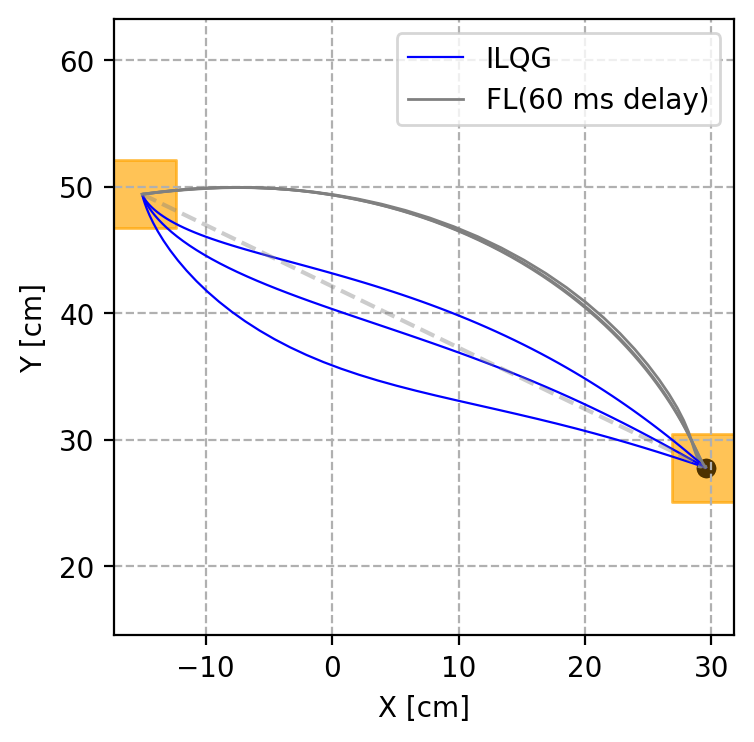

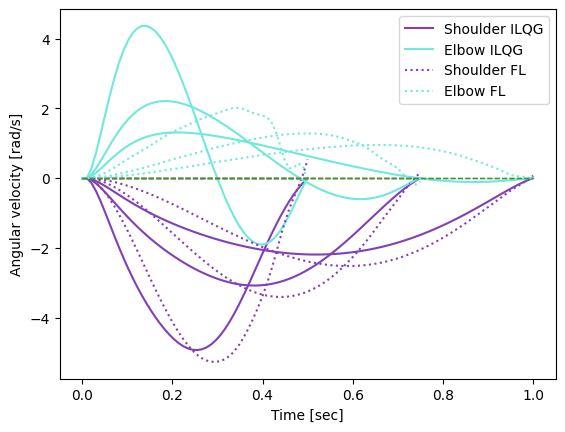

In [8]:
VerifyVel()

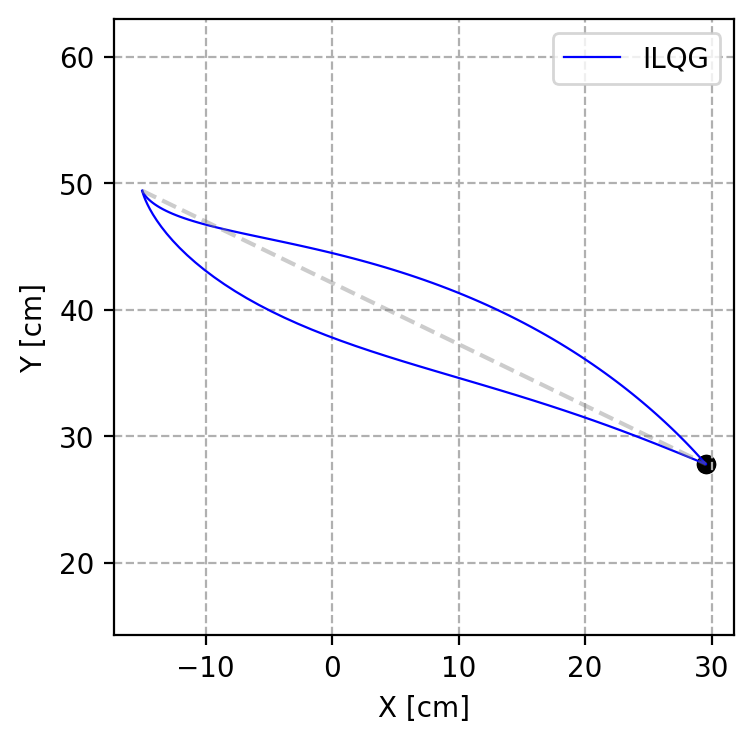

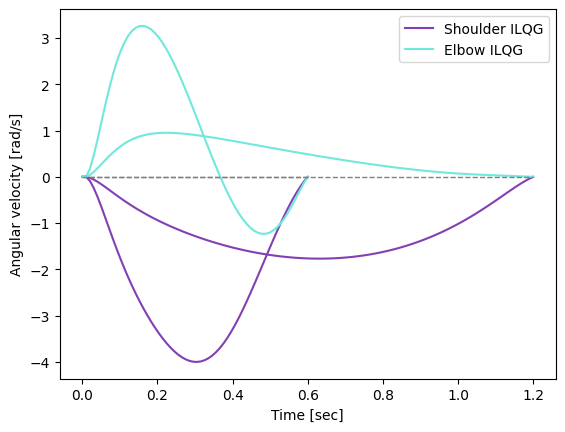

In [26]:
VerifyVel(timings=[.6,1.2],onlyILQG=True)

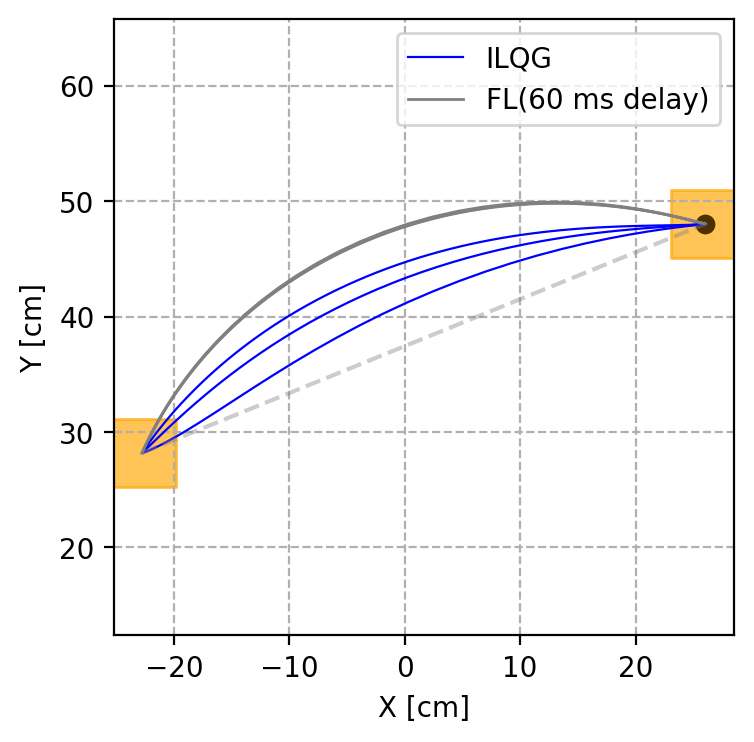

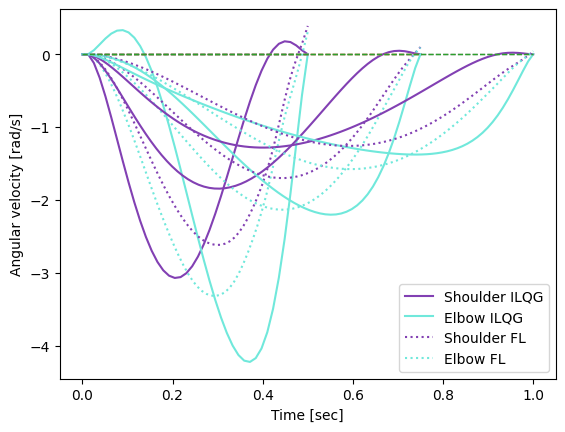

In [12]:
VerifyVel([70,110],[30,60],less = 10)


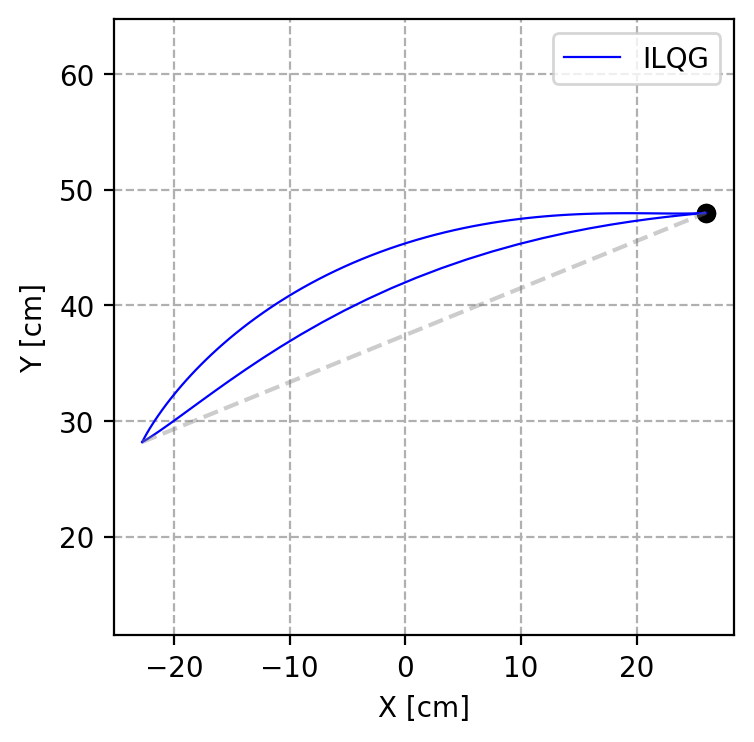

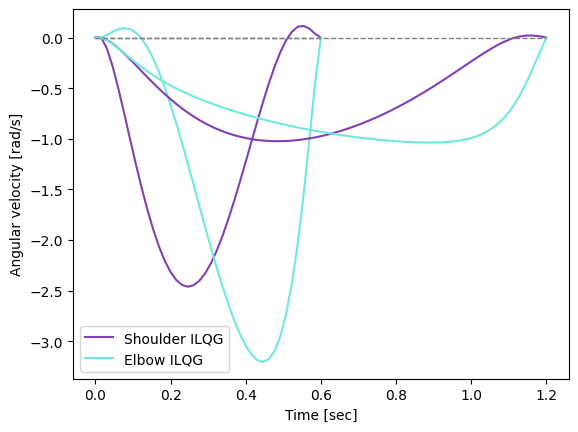

In [27]:
VerifyVel([70,110],[30,60],less = 20,timings=[.6,1.2],onlyILQG=True)